In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
from math import radians, sin, cos, sqrt, atan2

def save_processed_data(df, filename='final_processed_listings_data.csv'):
    """
    Save the processed DataFrame to CSV with proper index handling.
    
    Parameters:
    df (pd.DataFrame): DataFrame to save
    filename (str): Output filename
    """
    df.to_csv(filename, index=False)

# Prepare dataset

### Filter price data

In [3]:
def calculate_average_prices(file_path, start_date=None, end_date=None):
    """
    Calculate average prices per listing_id with optional date filtering.
    
    Parameters:
    file_path (str): Path to the CSV file
    start_date (str): Optional start date in 'YYYY-MM-DD' format
    end_date (str): Optional end date in 'YYYY-MM-DD' format
    
    Returns:
    DataFrame with average prices per listing_id
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Convert price column from string to float
    df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)
    
    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Apply date filters if provided
    if start_date:
        start_date = pd.to_datetime(start_date)
        df = df[df['date'] >= start_date]
    
    if end_date:
        end_date = pd.to_datetime(end_date)
        df = df[df['date'] <= end_date]
    
    # Calculate average price per listing_id
    avg_prices = df.groupby('listing_id')['price'].agg([
        'mean',
        'count',
        'min',
        'max',
        'std'
    ]).round(2)
    
    # Rename columns for clarity
    avg_prices.columns = ['avg_price', 'number_of_listings', 'min_price', 'max_price', 'price_std']
    
    # Generate output filename based on date range
    if start_date and end_date:
        filename = f'avg_prices_{start_date.strftime("%Y%m%d")}_to_{end_date.strftime("%Y%m%d")}.csv'
    elif start_date:
        filename = f'avg_prices_from_{start_date.strftime("%Y%m%d")}.csv'
    elif end_date:
        filename = f'avg_prices_to_{end_date.strftime("%Y%m%d")}.csv'
    else:
        filename = 'avg_prices_all_dates.csv'
    
    # Save to CSV
    avg_prices.to_csv(filename)
    
    return avg_prices

file_path = "raw_data/merged/calendar_filtered.csv"

# Example with date filtering
result = calculate_average_prices(
    file_path,
    start_date="2024-07-26",
    end_date="2024-08-11"
)

print("\nAnalysis complete! Summary of results:")
print(f"Total unique listings analyzed: {len(result)}")
print(f"Overall average price: ${result['avg_price'].mean():.2f}")
print(f"Price range: ${result['min_price'].min():.2f} - ${result['max_price'].max():.2f}")

C:\Users\sjokk\AppData\Local\Temp\ipykernel_11588\2485397495.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)



Analysis complete! Summary of results:
Total unique listings analyzed: 109557
Overall average price: $307.08
Price range: $0.00 - $901684.00


# Merge data into a single dataset
> Pre-processed listings detailed, average price for a given period, distance to venue, distance to station and city centre

In [9]:
def remove_price_outliers(df, price_column='price', method='iqr', threshold=3):
    """
    Remove price outliers using either IQR method or standard deviation method.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    price_column (str): Name of the price column
    method (str): 'iqr' for Interquartile Range or 'std' for Standard Deviation
    threshold (float): Multiplier for IQR or standard deviations
    
    Returns:
    pd.DataFrame: DataFrame with outliers removed
    """
    if method.lower() == 'iqr':
        Q1 = df[price_column].quantile(0.25)
        Q3 = df[price_column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
    else:  # std method
        mean = df[price_column].mean()
        std = df[price_column].std()
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
    
    # Create mask for prices within bounds and greater than 0
    price_mask = (df[price_column] >= lower_bound) & \
                 (df[price_column] <= upper_bound) & \
                 (df[price_column] > 0)
    
    cleaned_df = df[price_mask].copy()
    
    # Calculate what percentage of data was removed
    removed_percentage = (1 - len(cleaned_df) / len(df)) * 100
    
    print(f"\nOutlier Removal Summary:")
    print(f"Method used: {method.upper()}")
    print(f"Lower bound: ${lower_bound:.2f}")
    print(f"Upper bound: ${upper_bound:.2f}")
    print(f"Removed {removed_percentage:.1f}% of listings")
    print(f"Remaining listings: {len(cleaned_df)}")
    
    return cleaned_df

def calculate_average_prices(file_path, start_date=None, end_date=None, 
                           outlier_method='iqr', outlier_threshold=3):
    """
    Calculate average prices per listing_id with outlier removal and date range tracking.
    
    Parameters:
    file_path (str): Path to the CSV file
    start_date (str): Optional start date in 'YYYY-MM-DD' format
    end_date (str): Optional end date in 'YYYY-MM-DD' format
    outlier_method (str): Method for removing outliers ('iqr' or 'std')
    outlier_threshold (float): Threshold for outlier removal
    
    Returns:
    DataFrame with average prices and date range information per listing_id
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Convert price column from string to float
    df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)

    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Apply date filters if provided
    if start_date:
        start_date = pd.to_datetime(start_date)
        df = df[df['date'] >= start_date]
    
    if end_date:
        end_date = pd.to_datetime(end_date)
        df = df[df['date'] <= end_date]
    
    # Remove outliers
    df_cleaned = remove_price_outliers(df, 'price', outlier_method, outlier_threshold)
    
    # Calculate statistics per listing_id
    price_stats = df_cleaned.groupby('listing_id').agg({
        'price': ['mean', 'count', 'min', 'max', 'std'],
        'date': ['min', 'max']  # Add date range information
    })
    
    # Flatten column names
    price_stats.columns = [
        'avg_price', 'number_of_listings', 'min_price', 
        'max_price', 'price_std', 'price_period_start', 'price_period_end'
    ]
    
    # Round numerical columns
    numeric_columns = ['avg_price', 'min_price', 'max_price', 'price_std']
    price_stats[numeric_columns] = price_stats[numeric_columns].round(2)
    
    # Generate output filename
    date_part = ''
    if start_date and end_date:
        date_part = f'_{start_date.strftime("%Y%m%d")}_to_{end_date.strftime("%Y%m%d")}'
    elif start_date:
        date_part = f'_from_{start_date.strftime("%Y%m%d")}'
    elif end_date:
        date_part = f'_to_{end_date.strftime("%Y%m%d")}'
    
    filename = f'avg_prices{date_part}_clean_{outlier_method}.csv'
    
    # Save to CSV
    price_stats.to_csv(filename)
    
    print("\nFinal Analysis Summary:")
    print(f"Total unique listings analyzed: {len(price_stats)}")
    print(f"Overall average price: ${price_stats['avg_price'].mean():.2f}")
    print(f"Price range: ${price_stats['min_price'].min():.2f} - ${price_stats['max_price'].max():.2f}")
    print(f"Date range: {price_stats['price_period_start'].min():%Y-%m-%d} to {price_stats['price_period_end'].max():%Y-%m-%d}")
    
    return price_stats

def append_average_prices(main_file, price_data, remove_missing_prices=True):
    """
    Append average prices and date range information to the main dataset.
    
    Parameters:
    main_file (str): Path to the main CSV file
    price_data (pd.DataFrame): DataFrame containing average prices per listing
    remove_missing_prices (bool): If True, remove entries without price data
    
    Returns:
    pd.DataFrame: Updated main dataset
    """
    # Read main dataset
    main_df = pd.read_csv(main_file)
    initial_count = len(main_df)
    
    # Ensure price_data index is named correctly
    price_data = price_data.reset_index().rename(columns={'listing_id': 'id'})
    
    # Select columns to merge
    columns_to_merge = [
        'id', 'avg_price', 'price_period_start', 'price_period_end',
        'number_of_listings', 'price_std'
    ]
    
    # Merge price data
    if remove_missing_prices:
        # Inner join to keep only listings with price data
        result = main_df.merge(
            price_data[columns_to_merge],
            on='id',
            how='inner'
        )
    else:
        # Left join to keep all listings
        result = main_df.merge(
            price_data[columns_to_merge],
            on='id',
            how='left'
        )
    
    # Convert date columns to datetime for better formatting
    result['price_period_start'] = pd.to_datetime(result['price_period_start'])
    result['price_period_end'] = pd.to_datetime(result['price_period_end'])
    
    # Print merge summary
    final_count = len(result)
    removed_count = initial_count - final_count
    
    print("\nMerge Summary:")
    print(f"Initial number of listings: {initial_count}")
    print(f"Final number of listings: {final_count}")
    print(f"Listings removed: {removed_count} ({(removed_count/initial_count)*100:.1f}%)")
    print("\nDate Range Summary:")
    print(f"Earliest price data: {result['price_period_start'].min():%Y-%m-%d}")
    print(f"Latest price data: {result['price_period_end'].max():%Y-%m-%d}")
    
    return result

# Calculate average prices with date range information
price_results = calculate_average_prices(
    'raw_data/merged/calendar_filtered.csv',
    start_date='2024-07-26',
    end_date='2024-08-11',
    outlier_method='iqr',
    outlier_threshold=10
)

# Merge with main dataset, including date range information
main_df = append_average_prices(
    'cleaned_data/prepared/final_processed_listings_data.csv',
    price_results,
    remove_missing_prices=True
)

# Save the updated dataset
main_df.to_csv('cleaned_data/machine_learning/ml_final_processed_listings_data.csv', index=False)

C:\Users\sjokk\AppData\Local\Temp\ipykernel_11588\3125548327.py:61: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)



Outlier Removal Summary:
Method used: IQR
Lower bound: $-1510.00
Upper bound: $1850.00
Removed 1.5% of listings
Remaining listings: 4264859

Final Analysis Summary:
Total unique listings analyzed: 107937
Overall average price: $227.19
Price range: $1.00 - $1850.00
Date range: 2024-07-26 to 2024-08-11

Merge Summary:
Initial number of listings: 118804
Final number of listings: 107937
Listings removed: 10867 (9.1%)

Date Range Summary:
Earliest price data: 2024-07-26
Latest price data: 2024-08-11


In [15]:
def append_distance_data(main_df, file_configs):
    """
    Append specified distance columns from multiple datasets.
    
    Parameters:
    main_df (pd.DataFrame): Main DataFrame
    file_configs (list): List of dictionaries containing:
        - 'file_path': Path to the data CSV
        - 'columns': List of column names to append
        
    Returns:
    pd.DataFrame: Updated main dataset
    """
    result = main_df.copy()
    initial_count = len(result)
    
    print("\nStarting Distance Data Append Process:")
    print(f"Initial number of rows: {initial_count}")
    
    successfully_added_columns = []  # Track which columns were actually added
    
    for config in file_configs:
        file_path = config['file_path']
        columns = config['columns']
        
        print(f"\nProcessing file: {file_path}")
        print(f"Attempting to append columns: {columns}")
        
        try:
            # Read dataset
            distance_df = pd.read_csv(file_path)
            
            # Identify ID column
            id_col = 'id' if 'id' in distance_df.columns else 'listing_id'
            
            # Verify columns exist in source file
            available_columns = [col for col in columns if col in distance_df.columns]
            missing_columns = [col for col in columns if col not in distance_df.columns]
            
            if not available_columns:
                print(f"Error: None of the requested columns found in {file_path}")
                print(f"Available columns: {distance_df.columns.tolist()}")
                continue
                
            if missing_columns:
                print(f"Warning: Columns not found in file: {missing_columns}")
            
            columns_to_use = [id_col] + available_columns
            
            # Check for duplicates in source data
            duplicates = distance_df[id_col].duplicated().sum()
            if duplicates > 0:
                print(f"Warning: Found {duplicates} duplicate IDs in source file")
            
            # Merge specified columns
            print(f"Rows before merge: {len(result)}")
            
            result = result.merge(
                distance_df[columns_to_use],
                left_on='id',
                right_on=id_col,
                how='left'
            )
            
            # Clean up if ID column names were different
            if id_col != 'id' and f"{id_col}_y" in result.columns:
                result = result.drop(columns=[f"{id_col}_y"])
            
            print(f"Rows after merge: {len(result)}")
            
            # Track successfully added columns
            successfully_added_columns.extend(available_columns)
            
            # Report on null values for successfully added columns
            for col in available_columns:
                null_count = result[col].isnull().sum()
                if null_count > 0:
                    print(f"{col}: {null_count} nulls ({(null_count/len(result))*100:.1f}%)")
                    
        except Exception as e:
            print(f"Error processing file {file_path}: {str(e)}")
            continue
    
    # Final summary
    print("\nFinal Merge Summary:")
    print(f"Initial rows: {initial_count}")
    print(f"Final rows: {len(result)}")
    
    if successfully_added_columns:
        print("\nColumns successfully added:")
        for col in successfully_added_columns:
            non_null = result[col].notna().sum()
            print(f"{col}: {non_null} non-null values ({(non_null/len(result))*100:.1f}% coverage)")
    else:
        print("\nNo columns were successfully added")
    
    return result

# Usage example:
file_configs = [
    {
        'file_path': 'cleaned_data/summary_cleaned_airbnb_data.csv',
        'columns': ['closest_venue', 'distance_to_closest_venue']
    },
    {
        'file_path': 'paris_2024_data/airbnb_closest_stations.csv',
        'columns': ['distance_to_closest_station_km']
    }
]

# Read main dataset
main_df = pd.read_csv('cleaned_data/machine_learning/ml_final_processed_listings_data.csv')

# Append all distance data
result_df = append_distance_data(main_df, file_configs)

# Save the result
result_df.to_csv('cleaned_data/machine_learning/ml_final_processed_listings_data.csv', index=False)
print("\nFile saved successfully!")


Starting Distance Data Append Process:
Initial number of rows: 107937

Processing file: cleaned_data/summary_cleaned_airbnb_data.csv
Attempting to append columns: ['closest_venue', 'distance_to_closest_venue']
Rows before merge: 107937
Rows after merge: 107937

Processing file: paris_2024_data/airbnb_closest_stations.csv
Attempting to append columns: ['distance_to_closest_station_km']
Rows before merge: 107937
Rows after merge: 107937

Final Merge Summary:
Initial rows: 107937
Final rows: 107937

Columns successfully added:
closest_venue: 107937 non-null values (100.0% coverage)
distance_to_closest_venue: 107937 non-null values (100.0% coverage)
distance_to_closest_station_km: 107937 non-null values (100.0% coverage)

File saved successfully!


## Calculate city centre distance, and append

In [17]:
def calculate_distance_to_city_centre(df, city_center_coords):
    """
    Calculate distance from each listing to city centre using Haversine formula.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing latitude and longitude columns
    city_center_coords (tuple): (latitude, longitude) of city centre
    
    Returns:
    pd.Series: Distances in kilometers
    """
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371  # Earth's radius in kilometers
        
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        
        return R * c
    
    distances = df.apply(
        lambda row: haversine_distance(
            row['latitude'],
            row['longitude'],
            city_center_coords[0],
            city_center_coords[1]
        ),
        axis=1
    )
    
    return distances

# Define file path
file_path = 'cleaned_data/machine_learning/ml_final_processed_listings_data.csv'

# Read the data
print("Reading data...")
main_df = pd.read_csv(file_path)

# Define Paris city center coordinates
CITY_CENTER_COORDS = (48.864716, 2.349014)  # Paris

# Calculate distances
print("Calculating distances to city centre...")
main_df['distance_to_city_centre'] = calculate_distance_to_city_centre(
    main_df, 
    CITY_CENTER_COORDS
)

# Print summary statistics
print("\nDistance Summary Statistics:")
print(f"Average distance to city centre: {main_df['distance_to_city_centre'].mean():.2f} km")
print(f"Minimum distance: {main_df['distance_to_city_centre'].min():.2f} km")
print(f"Maximum distance: {main_df['distance_to_city_centre'].max():.2f} km")

# Save the updated dataset
print("\nSaving updated dataset...")
main_df.to_csv(file_path, index=False)
print(f"Data saved successfully to {file_path}")

# Verify the save
print("\nVerifying save...")
verify_df = pd.read_csv(file_path)
if 'distance_to_city_centre' in verify_df.columns:
    print("Verification successful: distance_to_city_centre column is present in saved file")
    print(f"Number of rows with distance calculated: {verify_df['distance_to_city_centre'].notna().sum()}")
else:
    print("Warning: distance_to_city_centre column not found in saved file!")

Reading data...
Calculating distances to city centre...

Distance Summary Statistics:
Average distance to city centre: 2.96 km
Minimum distance: 0.01 km
Maximum distance: 9.71 km

Saving updated dataset...
Data saved successfully to cleaned_data/machine_learning/ml_final_processed_listings_data.csv

Verifying save...
Verification successful: distance_to_city_centre column is present in saved file
Number of rows with distance calculated: 107937


### Removing unknown column in dataset

In [23]:
# Read the data, ignoring the index column
main_df = pd.read_csv('cleaned_data/machine_learning/ml_final_processed_listings_data.csv')

# Remove the Unnamed: 0 column if it exists
if 'bedrooms_imputed_method' in main_df.columns:
    main_df = main_df.drop(columns=['bedrooms_imputed_method', 'beds_imputed_method'])
    print("Removed 'bedrooms_imputed_method' column")
    print(f"Remaining columns: {len(main_df.columns)}")

# Save back to CSV without index
main_df.to_csv('cleaned_data/machine_learning/ml_final_processed_listings_data.csv', index=False)
print("File saved successfully without the index column!")

# Verify the save
verify_df = pd.read_csv('cleaned_data/machine_learning/ml_final_processed_listings_data.csv')
if 'bedrooms_imputed_method' not in verify_df.columns:
    print("Verification successful: 'price' column is not present in saved file")

Removed 'bedrooms_imputed_method' column
Remaining columns: 58
File saved successfully without the index column!
Verification successful: 'price' column is not present in saved file


# Split final dataset into training, validation and testing

Starting price prediction pipeline...
Reading data...
Loaded dataset with 107937 rows and 58 columns

Preparing features and target...
Found 5 categorical columns: ['host_is_superhost', 'property_type', 'room_type', 'neighbourhood_cleansed', 'instant_bookable']
Column 'host_is_superhost' has 2 unique values
Column 'property_type' has 69 unique values
Column 'room_type' has 4 unique values
Column 'neighbourhood_cleansed' has 20 unique values
Column 'instant_bookable' has 2 unique values
Found 32 numeric columns
Feature preparation completed

Examining categorical columns:

Unique values in property_type:
property_type
Entire rental unit              90507
Private room in rental unit      7194
Entire condo                     2930
Room in boutique hotel           1279
Entire loft                      1084
                                ...  
Shared room in guest suite          1
Floor                               1
Shared room in ice dome             1
Private room in earthen home     

C:\Users\sjokk\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\sjokk\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Model Performance Metrics:

Train Set:
R2 Score: 0.9328
RMSE: 63.7174
MAE: 35.9972

Val Set:
R2 Score: 0.5035
RMSE: 167.2660
MAE: 95.5614

Test Set:
R2 Score: 0.5056
RMSE: 164.9745
MAE: 94.3805

Analyzing feature importance...


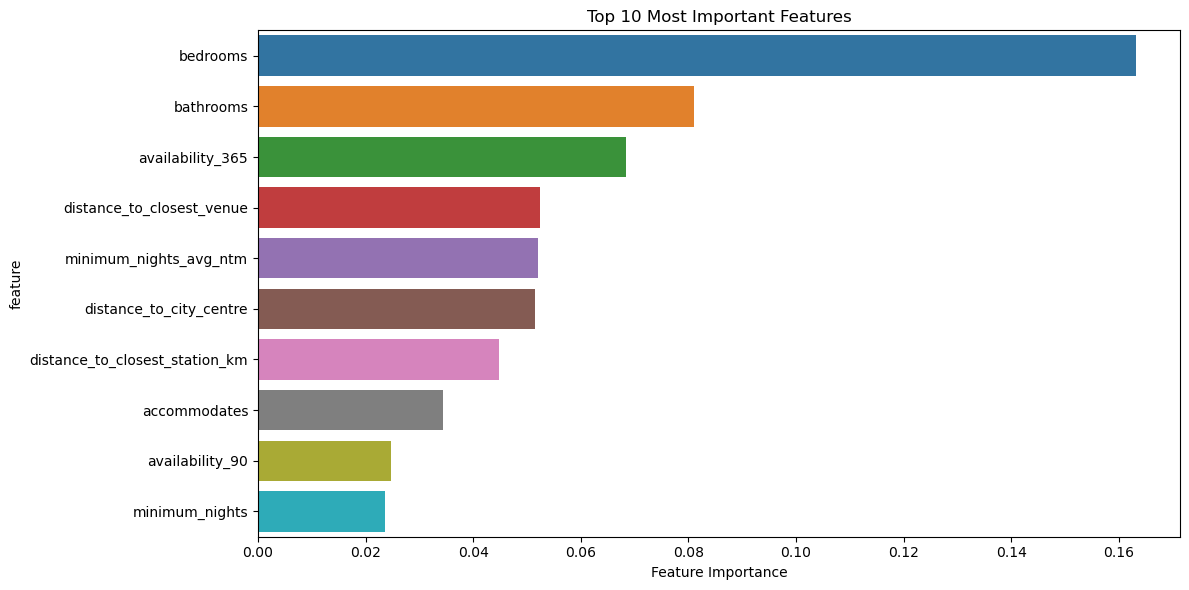

C:\Users\sjokk\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Creating prediction scatter plot...


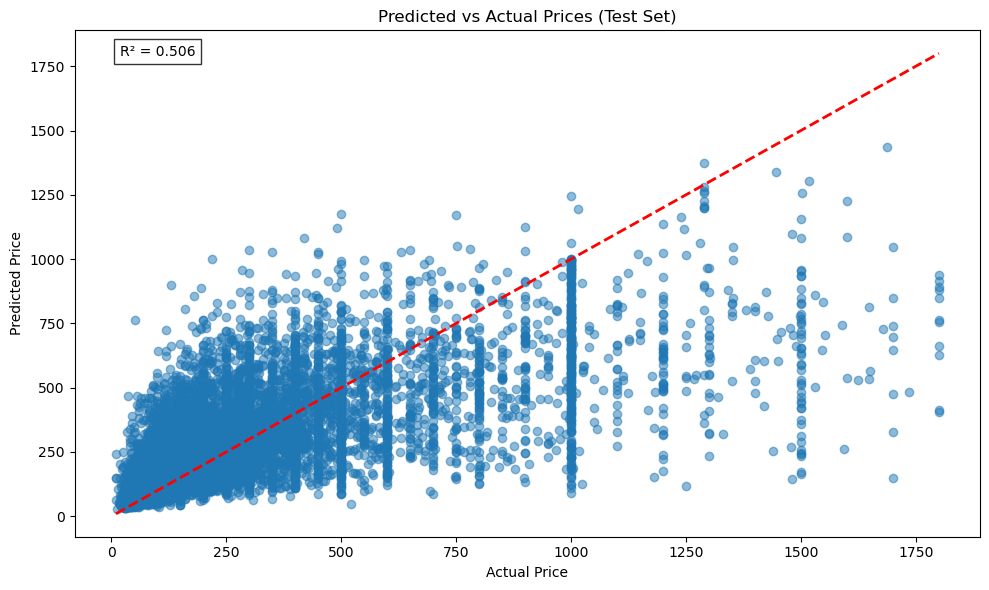

Scatter plot created

Top 10 Most Important Features:
                           feature  importance
4                         bedrooms    0.163165
3                        bathrooms    0.080987
13                availability_365    0.068304
29       distance_to_closest_venue    0.052321
8           minimum_nights_avg_ntm    0.052103
31         distance_to_city_centre    0.051446
30  distance_to_closest_station_km    0.044837
2                     accommodates    0.034365
12                 availability_90    0.024812
6                   minimum_nights    0.023568

Pipeline completed successfully!


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

def plot_prediction_scatter(y_true, y_pred, title):
    """
    Create scatter plot of predicted vs actual values.
    
    Parameters:
    y_true: Actual values
    y_pred: Predicted values
    title: Plot title
    """
    print("\nCreating prediction scatter plot...")
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(title)
    
    # Add R² value to plot
    r2 = r2_score(y_true, y_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.3f}', 
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    print("Scatter plot created")

def prepare_features_target(df, target_column='avg_price', exclude_columns=None):
    """
    Prepare feature matrix X and target variable y with categorical handling.
    """
    print("\nPreparing features and target...")
    
    if exclude_columns is None:
        exclude_columns = []
    
    # Add target column to exclude list
    exclude_columns = exclude_columns + [target_column]
    
    # Define categorical columns
    categorical_columns = [
        'host_is_superhost',
        'property_type',
        'room_type',
        'neighbourhood_cleansed',
        'instant_bookable',
        'bedrooms_imputed_method',
        'beds_imputed_method'
    ]
    
    # Remove excluded columns from categorical list
    categorical_columns = [col for col in categorical_columns 
                         if col in df.columns and col not in exclude_columns]
    
    print(f"Found {len(categorical_columns)} categorical columns: {categorical_columns}")
    
    # Print unique values in categorical columns for debugging
    for col in categorical_columns:
        n_unique = df[col].nunique()
        print(f"Column '{col}' has {n_unique} unique values")
    
    # Select features
    X = df.drop(columns=exclude_columns)
    
    # Identify numeric columns (excluding categorical)
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    numeric_cols = [col for col in numeric_cols if col not in categorical_columns]
    
    print(f"Found {len(numeric_cols)} numeric columns")
    
    # Get target variable
    y = df[target_column]
    
    # Create column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(
                drop='first', 
                sparse_output=False,
                handle_unknown='ignore'  # Added this parameter
            ), categorical_columns)
        ],
        remainder='drop'
    )
    
    print("Feature preparation completed")
    return X, y, preprocessor, numeric_cols, categorical_columns

def train_evaluate_model(X, y, preprocessor):
    """
    Train and evaluate the model using training, validation, and test sets.
    """
    print("\nStarting model training and evaluation...")
    
    # Create train, validation, and test sets
    print("Splitting data into train, validation, and test sets...")
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    print(f"Train set size: {len(X_train)}")
    print(f"Validation set size: {len(X_val)}")
    print(f"Test set size: {len(X_test)}")
    
    # Create and train pipeline
    print("\nCreating and training model pipeline...")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=100,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=42
        ))
    ])
    
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    print("Making predictions...")
    predictions = {
        'train': pipeline.predict(X_train),
        'val': pipeline.predict(X_val),
        'test': pipeline.predict(X_test)
    }
    
    # Calculate metrics
    metrics = {}
    for dataset, pred in predictions.items():
        y_true = {'train': y_train, 'val': y_val, 'test': y_test}[dataset]
        metrics[dataset] = {
            'R2 Score': r2_score(y_true, pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, pred)),
            'MAE': mean_absolute_error(y_true, pred)
        }
    
    print("\nModel Performance Metrics:")
    for dataset, m in metrics.items():
        print(f"\n{dataset.capitalize()} Set:")
        for metric_name, value in m.items():
            print(f"{metric_name}: {value:.4f}")
    
    return pipeline, metrics, (X_train, X_val, X_test, y_train, y_val, y_test)

def analyze_feature_importance(pipeline, numeric_cols, categorical_cols, n_top=10):
    """
    Analyze and plot feature importance with support for categorical features.
    """
    print("\nAnalyzing feature importance...")
    
    # Get feature names after preprocessing
    cat_features = []
    if categorical_cols:
        # Get categorical feature names after one-hot encoding
        cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat']
        cat_features = cat_encoder.get_feature_names_out(categorical_cols).tolist()
    
    feature_names = numeric_cols + cat_features
    
    # Get feature importance
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': pipeline.named_steps['regressor'].feature_importances_
    })
    
    # Sort by importance
    importance = importance.sort_values('importance', ascending=False)
    
    # Plot top N features
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance.head(n_top), x='importance', y='feature')
    plt.title(f'Top {n_top} Most Important Features')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return importance

# Main execution
if __name__ == "__main__":
    print("Starting price prediction pipeline...")
    
    # Columns to exclude from features
    exclude_cols = [
        # Identifiers
        'id', 'host_id',
        
        # Dates
        'last_scraped', 'first_review', 'last_review', 
        'calendar_last_scraped', 'price_period_start', 'price_period_end',
        
        # Text fields
        'name', 'amenities',
        
        # Redundant/derivative fields
        'minimum_minimum_nights', 'maximum_minimum_nights',
        'minimum_maximum_nights', 'maximum_maximum_nights',
        
        # Meta information
        'number_of_listings', 'price_std',
        
        # Location (might want to keep these depending on your needs)
        'latitude', 'longitude',
        
        # Target-related
        'avg_price'
    ]
    
    # Read the data
    print("Reading data...")
    df = pd.read_csv('cleaned_data/machine_learning/ml_final_processed_listings_data.csv')
    print(f"Loaded dataset with {len(df)} rows and {len(df.columns)} columns")
    
    # Prepare features and target
    X, y, preprocessor, numeric_cols, categorical_cols = prepare_features_target(
        df, 
        target_column='avg_price',
        exclude_columns=exclude_cols
    )
    # After reading the data, add this diagnostic section:
    print("\nExamining categorical columns:")
    for col in ['property_type', 'room_type']:  # Add other categorical columns as needed
        print(f"\nUnique values in {col}:")
        print(df[col].value_counts())
        
    # Train and evaluate model
    pipeline, metrics, split_data = train_evaluate_model(X, y, preprocessor)
    
    # Analyze feature importance
    importance_df = analyze_feature_importance(pipeline, numeric_cols, categorical_cols)
    
    # Plot predictions vs actual for test set
    X_train, X_val, X_test, y_train, y_val, y_test = split_data
    y_pred_test = pipeline.predict(X_test)
    plot_prediction_scatter(y_test, y_pred_test, 'Predicted vs Actual Prices (Test Set)')
    
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))
    
    print("\nPipeline completed successfully!")

# Improved

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
from scipy.stats import randint, uniform
import warnings
import logging
import joblib
from pathlib import Path

class ImprovedPricePredictionPipeline:
    def __init__(self, random_state: int = 42):
        self.random_state = random_state
        self.pipeline = None
        self.feature_names = None
        self.metrics = None
        
    def create_olympic_specific_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create Olympics-specific features from the dataset."""
        df = df.copy()
        
        # Create interaction features
        df['price_per_person'] = df['avg_price'] / df['accommodates']
        df['beds_per_bedroom'] = df['beds'] / df['bedrooms'].replace(0, 1)
        df['reviews_density'] = df['number_of_reviews'] / (df['review_scores_rating'] + 1)
        
        # Create Olympic venue proximity features
        df['venue_premium'] = np.exp(-df['distance_to_closest_venue'] / 1000)  # Exponential decay
        df['transport_access'] = np.exp(-df['distance_to_closest_station_km'])
        
        # Create composite scores
        df['quality_score'] = df[[
            'review_scores_rating', 'review_scores_cleanliness',
            'review_scores_location', 'review_scores_value'
        ]].mean(axis=1)
        
        # Create seasonal features from dates
        df['price_period_start'] = pd.to_datetime(df['price_period_start'])
        df['is_summer'] = df['price_period_start'].dt.month.isin([6, 7, 8]).astype(int)
        df['is_weekend'] = df['price_period_start'].dt.dayofweek.isin([4, 5, 6]).astype(int)
        
        return df

    def prepare_features_target(self, df: pd.DataFrame, 
                              target_column: str = 'avg_price',
                              exclude_columns: List[str] = None) -> Tuple:
        """Enhanced feature preparation with Olympics-specific processing."""
        logger.info("Preparing features with Olympic-specific enhancements...")
        
        # Create Olympic-specific features
        df = self.create_olympic_specific_features(df)
        
        exclude_columns = exclude_columns or []
        exclude_columns = exclude_columns + [target_column]
        
        # Define categorical columns with improved cardinality handling
        categorical_columns = []
        for col in df.select_dtypes(include=['object', 'category']).columns:
            if col not in exclude_columns:
                unique_count = df[col].nunique()
                if unique_count < 50:  # Reduced threshold for Olympic-specific categorization
                    categorical_columns.append(col)
        
        # Select features
        X = df.drop(columns=exclude_columns)
        
        # Identify numeric columns
        numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
        numeric_cols = [col for col in numeric_cols if col not in categorical_columns]
        
        # Get target variable and apply log transformation for price
        y = np.log1p(df[target_column])  # Log transform for better price distribution
        
        # Create enhanced preprocessing pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', Pipeline([
                    ('scaler', RobustScaler()),
                    ('power', PowerTransformer(method='yeo-johnson')),  # Handle skewed features
                    ('poly', PolynomialFeatures(degree=2, include_bias=False))  # Capture non-linear relationships
                ]), numeric_cols),
                ('cat', Pipeline([
                    ('onehot', OneHotEncoder(
                        drop='if_binary',
                        sparse_output=False,
                        handle_unknown='ignore',
                        min_frequency=0.05  # Increased threshold for Olympic-specific categories
                    ))
                ]), categorical_columns)
            ],
            remainder='drop',
            verbose_feature_names_out=True
        )
        
        return X, y, preprocessor, numeric_cols, categorical_columns

    def train_evaluate_model(self, X: pd.DataFrame, y: pd.Series, 
                           preprocessor: ColumnTransformer,
                           cv_folds: int = 5) -> Tuple:
        """Enhanced training with RandomizedSearchCV and time series consideration."""
        logger.info("Starting advanced model training with RandomizedSearchCV...")
        
        # Time-based split for Olympic period consideration
        X_train, X_temp = train_test_split(X, test_size=0.3, shuffle=False)
        y_train, y_temp = y.iloc[X_train.index], y.iloc[X_temp.index]
        X_val, X_test = train_test_split(X_temp, test_size=0.5, shuffle=False)
        y_val, y_test = y_temp.iloc[X_val.index], y_temp.iloc[X_test.index]
        
        # Define parameter distributions for RandomizedSearchCV
        param_distributions = {
            'regressor__learning_rate': uniform(0.01, 0.3),
            'regressor__max_depth': randint(3, 50),
            'regressor__min_samples_leaf': randint(1, 20),
            'regressor__max_iter': randint(100, 500),
            'regressor__max_bins': randint(100, 255),  # Specific to HistGradientBoosting
            'regressor__l2_regularization': uniform(0, 10)
        }
        
        # Create base pipeline
        base_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', HistGradientBoostingRegressor(random_state=self.random_state))
        ])
        
        # Custom scorer that combines multiple metrics
        def custom_scorer(y_true, y_pred):
            # Convert back from log scale
            y_true_orig = np.expm1(y_true)
            y_pred_orig = np.expm1(y_pred)
            
            r2 = r2_score(y_true_orig, y_pred_orig)
            rmse = -np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
            mape = -np.mean(np.abs((y_true_orig - y_pred_orig) / y_true_orig))
            
            return 0.4 * r2 + 0.4 * (-rmse/1000) + 0.2 * (-mape)  # Weighted combination
        
        # Create time series cross-validation
        tscv = TimeSeriesSplit(n_splits=cv_folds)
        
        # Perform randomized search with time series cross-validation
        random_search = RandomizedSearchCV(
            base_pipeline,
            param_distributions=param_distributions,
            n_iter=50,  # Number of parameter settings sampled
            cv=tscv,
            scoring=make_scorer(custom_scorer),
            n_jobs=-1,
            random_state=self.random_state,
            verbose=2
        )
        
        # Fit the model
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=ConvergenceWarning)
            random_search.fit(X_train, y_train)
        
        self.pipeline = random_search.best_estimator_
        
        # Calculate metrics with price transformation reversal
        predictions = {}
        self.metrics = {}
        
        for name, (X_set, y_set) in [
            ('train', (X_train, y_train)),
            ('val', (X_val, y_val)),
            ('test', (X_test, y_test))
        ]:
            pred = self.pipeline.predict(X_set)
            predictions[name] = np.expm1(pred)  # Reverse log transformation
            true_prices = np.expm1(y_set)
            
            self.metrics[name] = {
                'R2 Score': r2_score(true_prices, predictions[name]),
                'RMSE': np.sqrt(mean_squared_error(true_prices, predictions[name])),
                'MAE': mean_absolute_error(true_prices, predictions[name]),
                'MAPE': np.mean(np.abs((true_prices - predictions[name]) / true_prices)) * 100
            }
        
        # Log best parameters
        logger.info(f"Best parameters found: {random_search.best_params_}")
        logger.info(f"Best cross-validation score: {random_search.best_score_}")
        
        return self.pipeline, self.metrics, (X_train, X_val, X_test, y_train, y_val, y_test)

    def analyze_feature_importance(self, numeric_cols: List[str], 
                                 categorical_cols: List[str], 
                                 n_top: int = 15,
                                 save_path: str = None) -> pd.DataFrame:
        """Enhanced feature importance analysis."""
        logger.info("Analyzing feature importance...")
        
        if self.pipeline is None:
            raise ValueError("Model must be trained before analyzing feature importance")
        
        # Get feature names
        feature_names = (
            numeric_cols + 
            self.pipeline.named_steps['preprocessor']
            .named_transformers_['cat']
            .get_feature_names_out(categorical_cols).tolist()
        )
        
        # Get feature importance
        importance = pd.DataFrame({
            'feature': feature_names,
            'importance': self.pipeline.named_steps['regressor'].feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Enhanced visualization
        plt.figure(figsize=(12, 8))
        sns.barplot(
            data=importance.head(n_top),
            x='importance',
            y='feature',
            palette='viridis'
        )
        plt.title('Top Feature Importance for Olympic Price Prediction', pad=20)
        plt.xlabel('Feature Importance', labelpad=10)
        plt.ylabel('Feature', labelpad=10)
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            logger.info(f"Feature importance plot saved to {save_path}")
        
        plt.tight_layout()
        plt.show()
        
        return importance

    def save_model(self, path: str) -> None:
        """Save the trained model and preprocessor."""
        if self.pipeline is None:
            raise ValueError("Model must be trained before saving")
        
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        joblib.dump(self.pipeline, path)
        logger.info(f"Model saved to {path}")

    @staticmethod
    def load_model(path: str) -> 'PricePredictionPipeline':
        """Load a trained model."""
        pipeline = joblib.load(path)
        instance = ImprovedPricePredictionPipeline()
        instance.pipeline = pipeline
        logger.info(f"Model loaded from {path}")
        return instance

def main():
    logger.info("Starting price prediction pipeline...")
    
    # Columns to exclude from features
    exclude_cols = [
        'id', 'host_id',
        'last_scraped', 'first_review', 'last_review',
        'calendar_last_scraped', 'price_period_start', 'price_period_end',
        'name', 'amenities',
        'minimum_minimum_nights', 'maximum_minimum_nights',
        'minimum_maximum_nights', 'maximum_maximum_nights',
        'number_of_listings', 'price_std',
        'latitude', 'longitude',
        'avg_price'
    ]
    
    try:
        # Create output directory
        output_dir = Path('output')
        output_dir.mkdir(exist_ok=True)
        
        # Read the data
        df = pd.read_csv('cleaned_data/machine_learning/ml_final_processed_listings_data.csv')
        logger.info(f"Loaded dataset with {len(df)} rows and {len(df.columns)} columns")
        
        # Initialize and run pipeline
        pipeline = ImprovedPricePredictionPipeline()
        X, y, preprocessor, numeric_cols, categorical_cols = pipeline.prepare_features_target(
            df, 
            target_column='avg_price',
            exclude_columns=exclude_cols
        )
        
        # Train and evaluate model
        model, metrics, split_data = pipeline.train_evaluate_model(X, y, preprocessor)
        
        # Analyze and plot results
        X_train, X_val, X_test, y_train, y_val, y_test = split_data
        y_pred_test = model.predict(X_test)
        
        pipeline.plot_prediction_scatter(
            y_test, 
            y_pred_test, 
            'Predicted vs Actual Prices (Test Set)',
            save_path=output_dir / 'prediction_scatter.png'
        )
        
        importance_df = pipeline.analyze_feature_importance(
            numeric_cols, 
            categorical_cols,
            save_path=output_dir / 'feature_importance.png'
        )
        
        # Save model
        pipeline.save_model(output_dir / 'price_prediction_model.joblib')
        
        # Save metrics to file
        pd.DataFrame(metrics).to_csv(output_dir / 'model_metrics.csv')
        
        logger.info("Pipeline completed successfully!")
        
    except Exception as e:
        logger.error(f"An error occurred: {str(e)}", exc_info=True)
        raise

if __name__ == "__main__":
    main()

2024-11-04 23:41:49,913 - INFO - Starting price prediction pipeline...
2024-11-04 23:41:51,999 - INFO - Loaded dataset with 107937 rows and 58 columns
2024-11-04 23:41:51,999 - INFO - Preparing features with Olympic-specific enhancements...
2024-11-04 23:41:52,169 - INFO - Starting advanced model training with RandomizedSearchCV...
2024-11-04 23:41:52,200 - ERROR - An error occurred: positional indexers are out-of-bounds
Traceback (most recent call last):
  File "C:\Users\sjokk\miniconda3\Lib\site-packages\pandas\core\indexing.py", line 1714, in _get_list_axis
    return self.obj._take_with_is_copy(key, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\sjokk\miniconda3\Lib\site-packages\pandas\core\generic.py", line 4153, in _take_with_is_copy
    result = self.take(indices=indices, axis=axis)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\sjokk\miniconda3\Lib\site-packages\pandas\core\generic.py", line 4133, in take
    new_data = 

IndexError: positional indexers are out-of-bounds

# Multiple models

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import logging
from pathlib import Path
import warnings
import joblib
from datetime import datetime
from typing import Dict, Any, List

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

class MultiModelPricePrediction:
    def __init__(self, random_state: int = 42, tolerance: float = 5.0):
        self.random_state = random_state
        self.tolerance = tolerance
        self.models = self._initialize_models()
        self.results = {}
        
    def _initialize_models(self) -> Dict[str, Any]:
        """Initialize all models with basic parameters."""
        return {
            'Linear_Regression': LinearRegression(),
            'Ridge': Ridge(random_state=self.random_state),
            'Lasso': Lasso(random_state=self.random_state),
            'Decision_Tree': DecisionTreeRegressor(random_state=self.random_state),
            'Random_Forest': RandomForestRegressor(
                n_estimators=100,
                random_state=self.random_state,
                n_jobs=-1
            ),
            'Gradient_Boost': GradientBoostingRegressor(
                n_estimators=100,
                random_state=self.random_state
            ),
            'SVR': SVR(kernel='rbf'),
            'Neural_Network': MLPRegressor(
                hidden_layer_sizes=(100, 50),
                max_iter=500,
                random_state=self.random_state
            )
        }

    def calculate_metrics(self, y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """Calculate comprehensive metrics including tolerance-based ones."""
        abs_diff = np.abs(y_true - y_pred)
        
        metrics = {
            'R2_Score': r2_score(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            f'Within_{self.tolerance}dollars': np.mean(abs_diff <= self.tolerance) * 100,
            'Within_1dollar': np.mean(abs_diff <= 1.0) * 100,
            'Within_2dollars': np.mean(abs_diff <= 2.0) * 100,
            'Mean_Error': np.mean(abs_diff),
            'Median_Error': np.median(abs_diff),
            'Max_Error': np.max(abs_diff)
        }
        
        return metrics

    def prepare_data(self, df: pd.DataFrame, 
                    target_column: str = 'avg_price',
                    exclude_columns: List[str] = None) -> tuple:
        """Prepare data with preprocessing pipeline."""
        logger.info("Preparing data...")
        
        exclude_columns = exclude_columns or []
        exclude_columns = exclude_columns + [target_column]
        
        # Define categorical columns
        categorical_columns = []
        for col in df.select_dtypes(include=['object', 'category']).columns:
            if col not in exclude_columns:
                unique_count = df[col].nunique()
                if unique_count < 100:
                    categorical_columns.append(col)
                    logger.info(f"Column '{col}' identified as categorical with {unique_count} unique values")
        
        # Select features
        X = df.drop(columns=exclude_columns)
        
        # Identify numeric columns
        numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
        numeric_cols = [col for col in numeric_cols if col not in categorical_columns]
        
        logger.info(f"Number of numeric columns: {len(numeric_cols)}")
        logger.info(f"Number of categorical columns: {len(categorical_columns)}")
        
        # Create preprocessor
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(
                drop='if_binary',
                sparse_output=False,
                handle_unknown='ignore'
            ))
        ])
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_cols),
                ('cat', categorical_transformer, categorical_columns)
            ],
            remainder='drop'
        )
        
        # Get target variable
        y = df[target_column]
        
        # Remove rows with missing target values
        if y.isnull().any():
            valid_idx = y.notnull()
            X = X[valid_idx]
            y = y[valid_idx]
        
        return X, y, preprocessor

    def train_and_evaluate(self, X: pd.DataFrame, y: pd.Series, preprocessor: ColumnTransformer) -> pd.DataFrame:
        """Train all models and evaluate their performance."""
        logger.info("Starting model training and evaluation...")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=self.random_state
        )
        
        results_list = []
        
        # Train and evaluate each model
        for model_name, model in self.models.items():
            try:
                logger.info(f"Training {model_name}...")
                
                # Create pipeline
                pipeline = Pipeline([
                    ('preprocessor', preprocessor),
                    ('regressor', model)
                ])
                
                # Train model
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore')
                    pipeline.fit(X_train, y_train)
                
                # Make predictions
                y_pred_train = pipeline.predict(X_train)
                y_pred_test = pipeline.predict(X_test)
                
                # Calculate metrics
                train_metrics = self.calculate_metrics(y_train, y_pred_train)
                test_metrics = self.calculate_metrics(y_test, y_pred_test)
                
                # Store results
                result = {
                    'Model': model_name,
                    'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                }
                
                # Add train metrics
                for metric_name, value in train_metrics.items():
                    result[f'Train_{metric_name}'] = value
                
                # Add test metrics
                for metric_name, value in test_metrics.items():
                    result[f'Test_{metric_name}'] = value
                
                results_list.append(result)
                
                # Save the model
                model_path = Path('output/models')
                model_path.mkdir(parents=True, exist_ok=True)
                joblib.dump(pipeline, model_path / f'{model_name}_pipeline.joblib')
                
                logger.info(f"Completed training {model_name}")
                
            except Exception as e:
                logger.error(f"Error training {model_name}: {str(e)}")
                continue
        
        # Create DataFrame with results
        results_df = pd.DataFrame(results_list)
        
        # Save results
        output_path = Path('output')
        output_path.mkdir(exist_ok=True)
        results_df.to_csv(output_path / 'model_comparison_results.csv', index=False)
        
        return results_df

def main():
    logger.info("Starting price prediction pipeline...")
    
    try:
        # Create output directory
        output_dir = Path('output')
        output_dir.mkdir(exist_ok=True)
        
        # Read the data
        df = pd.read_csv('cleaned_data/machine_learning/ml_final_processed_listings_data.csv')
        logger.info(f"Loaded dataset with {len(df)} rows and {len(df.columns)} columns")
        
        # Columns to exclude
        exclude_cols = [
            'id', 'host_id',
            'last_scraped', 'first_review', 'last_review',
            'calendar_last_scraped', 'price_period_start', 'price_period_end',
            'name', 'amenities',
            'minimum_minimum_nights', 'maximum_minimum_nights',
            'minimum_maximum_nights', 'maximum_maximum_nights',
            'number_of_listings', 'price_std',
            'latitude', 'longitude',
            'avg_price'
        ]
        
        # Initialize pipeline
        pipeline = MultiModelPricePrediction()
        
        # Prepare data
        X, y, preprocessor = pipeline.prepare_data(
            df, 
            target_column='avg_price',
            exclude_columns=exclude_cols
        )
        
        # Train and evaluate all models
        results = pipeline.train_and_evaluate(X, y, preprocessor)
        
        # Display results
        print("\nModel Comparison Results:")
        print(results.to_string())
        
        logger.info("Pipeline completed successfully!")
        
    except Exception as e:
        logger.error(f"An error occurred: {str(e)}", exc_info=True)
        raise

if __name__ == "__main__":
    main()

2024-11-04 22:14:54,509 - INFO - Starting price prediction pipeline...
2024-11-04 22:14:56,004 - INFO - Loaded dataset with 107937 rows and 58 columns
2024-11-04 22:14:56,005 - INFO - Preparing data...
2024-11-04 22:14:56,023 - INFO - Column 'neighbourhood_cleansed' identified as categorical with 20 unique values
2024-11-04 22:14:56,029 - INFO - Column 'property_type' identified as categorical with 69 unique values
2024-11-04 22:14:56,035 - INFO - Column 'room_type' identified as categorical with 4 unique values
2024-11-04 22:14:56,039 - INFO - Column 'has_availability' identified as categorical with 2 unique values
2024-11-04 22:14:56,043 - INFO - Column 'instant_bookable' identified as categorical with 2 unique values
2024-11-04 22:14:56,050 - INFO - Column 'closest_venue' identified as categorical with 25 unique values
2024-11-04 22:14:56,068 - INFO - Number of numeric columns: 32
2024-11-04 22:14:56,069 - INFO - Number of categorical columns: 6
2024-11-04 22:14:56,070 - INFO - Star


Model Comparison Results:
               Model            Timestamp  Train_R2_Score  Train_RMSE   Train_MAE  Train_Within_5.0dollars  Train_Within_1dollar  Train_Within_2dollars  Train_Mean_Error  Train_Median_Error  Train_Max_Error  Test_R2_Score     Test_RMSE      Test_MAE  Test_Within_5.0dollars  Test_Within_1dollar  Test_Within_2dollars  Test_Mean_Error  Test_Median_Error  Test_Max_Error
0  Linear_Regression  2024-11-04 22:14:57        0.333500  199.570616  122.992889                 3.715156              0.823403               1.549526        122.992889           77.500000      3335.000000  -6.987978e+18  6.251395e+11  4.254718e+09                3.617751             0.787475              1.491569     4.254718e+09          78.500000    9.185084e+13
1              Ridge  2024-11-04 22:14:58        0.366400  194.582765  117.373553                 3.752215              0.804873               1.525206        117.373553           72.480146      3360.600902   2.495402e-01  2.048637e+02

# Visualize

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path

class EnhancedModelVisualization:
    def __init__(self, results_path: str = 'output/model_comparison_results.csv'):
        """Initialize with path to results CSV file."""
        self.results_df = pd.read_csv(results_path)
        self.output_dir = Path('output/visualizations')
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        # Filter out extremely poor performing models
        self.filter_outlier_models()
        
    def filter_outlier_models(self, r2_threshold: float = -1.0):
        """Remove models with extremely poor performance."""
        original_count = len(self.results_df)
        self.results_df = self.results_df[self.results_df['Test_R2_Score'] > r2_threshold]
        filtered_count = len(self.results_df)
        
        if filtered_count < original_count:
            print(f"Filtered out {original_count - filtered_count} models with R² score below {r2_threshold}")
            print("Filtered models:", self.results_df[~self.results_df['Test_R2_Score'].gt(r2_threshold)]['Model'].tolist())
    
    def plot_overall_comparison(self):
        """Create a comprehensive comparison of all models."""
        metrics = ['R2_Score', 'RMSE', 'MAE', 'Within_5.0dollars']
        test_metrics = [f'Test_{metric}' for metric in metrics]
        
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=[metric.replace('Test_', '').replace('_', ' ') for metric in test_metrics]
        )
        
        for idx, metric in enumerate(test_metrics, 1):
            row = (idx - 1) // 2 + 1
            col = (idx - 1) % 2 + 1
            
            # Sort models by metric value
            sorted_df = self.results_df.sort_values(metric, ascending='RMSE' in metric or 'MAE' in metric)
            
            fig.add_trace(
                go.Bar(
                    x=sorted_df['Model'],
                    y=sorted_df[metric],
                    name=metric.replace('Test_', ''),
                    text=sorted_df[metric].round(2),
                    textposition='auto',
                    hovertemplate="%{x}<br>%{y:.2f}<extra></extra>"
                ),
                row=row, col=col
            )
            
            # Update axes labels
            fig.update_xaxes(title_text="Model", row=row, col=col)
            fig.update_yaxes(title_text=metric.replace('Test_', '').replace('_', ' '), row=row, col=col)
        
        fig.update_layout(
            height=800,
            width=1200,
            title_text="Model Performance Comparison",
            showlegend=False,
            template="plotly_white"
        )
        
        fig.write_html(self.output_dir / 'overall_comparison.html')
        fig.show()
    
    def plot_tolerance_comparison(self):
        """Plot tolerance-based metrics comparison."""
        tolerance_cols = [col for col in self.results_df.columns 
                         if 'Within' in col and 'Test' in col]
        
        # Melt the dataframe for easier plotting
        melted_df = pd.melt(
            self.results_df,
            id_vars=['Model'],
            value_vars=tolerance_cols,
            var_name='Tolerance',
            value_name='Percentage'
        )
        
        # Clean up tolerance labels
        melted_df['Tolerance'] = melted_df['Tolerance'].apply(
            lambda x: x.replace('Test_Within_', '')
                      .replace('dollars', ' dollars')
                      .replace('.0', '')
        )
        
        # Sort models by their best performance
        model_order = self.results_df.sort_values('Test_Within_5.0dollars', ascending=False)['Model'].tolist()
        
        fig = px.bar(
            melted_df,
            x='Model',
            y='Percentage',
            color='Tolerance',
            title='Percentage of Predictions Within Different Price Ranges',
            barmode='group',
            category_orders={"Model": model_order}
        )
        
        fig.update_layout(
            height=600,
            width=1200,
            yaxis_title="Percentage of Predictions (%)",
            xaxis_title="Model",
            template="plotly_white"
        )
        
        fig.write_html(self.output_dir / 'tolerance_comparison.html')
        fig.show()
    
    def plot_train_test_comparison(self):
        """Plot training vs test performance with error bars."""
        metrics = ['R2_Score', 'RMSE', 'MAE']
        
        fig = make_subplots(
            rows=len(metrics), cols=1,
            subplot_titles=[f"{metric.replace('_', ' ')} - Train vs Test" for metric in metrics],
            height=300 * len(metrics)
        )
        
        colors = {'Train': '#1f77b4', 'Test': '#ff7f0e'}
        
        for idx, metric in enumerate(metrics, 1):
            # Sort models by test performance
            sort_ascending = 'RMSE' in metric or 'MAE' in metric
            sorted_df = self.results_df.sort_values(f'Test_{metric}', ascending=sort_ascending)
            
            for dataset in ['Train', 'Test']:
                fig.add_trace(
                    go.Bar(
                        name=f'{dataset} {metric}',
                        x=sorted_df['Model'],
                        y=sorted_df[f'{dataset}_{metric}'],
                        text=sorted_df[f'{dataset}_{metric}'].round(2),
                        textposition='auto',
                        marker_color=colors[dataset],
                        showlegend=idx==1,
                        hovertemplate="%{x}<br>%{y:.2f}<extra></extra>"
                    ),
                    row=idx, col=1
                )
        
        fig.update_layout(
            title_text="Train vs Test Performance Comparison",
            width=1200,
            showlegend=True,
            barmode='group',
            template="plotly_white"
        )
        
        fig.write_html(self.output_dir / 'train_test_comparison.html')
        fig.show()
    
    def create_summary_report(self):
        """Create an enhanced summary report with relative performance scores."""
        # Calculate rankings for each metric
        ranking_metrics = [col for col in self.results_df.columns 
                         if 'Test_' in col and col != 'Test_Max_Error']
        
        # Initialize rankings dataframe
        rankings = pd.DataFrame()
        
        # Calculate rankings and normalized scores
        for metric in ranking_metrics:
            ascending = 'RMSE' in metric or 'MAE' in metric
            
            # Calculate rank
            rankings[f'{metric}_rank'] = self.results_df[metric].rank(ascending=ascending)
            
            # Calculate normalized score (0-100)
            if ascending:
                rankings[f'{metric}_score'] = 100 * (self.results_df[metric].max() - self.results_df[metric]) / (self.results_df[metric].max() - self.results_df[metric].min())
            else:
                rankings[f'{metric}_score'] = 100 * (self.results_df[metric] - self.results_df[metric].min()) / (self.results_df[metric].max() - self.results_df[metric].min())
        
        # Calculate average scores
        rankings['Average_Score'] = rankings[[col for col in rankings.columns if 'score' in col]].mean(axis=1)
        self.results_df['Overall_Score'] = rankings['Average_Score']
        
        # Sort by overall score
        summary = self.results_df.sort_values('Overall_Score', ascending=False)
        
        # Create summary visualization
        fig = go.Figure(data=[
            go.Table(
                header=dict(
                    values=['Model', 'Overall_Score'] + [col for col in self.results_df.columns 
                                                       if 'Test_' in col],
                    font=dict(size=12),
                    align='left'
                ),
                cells=dict(
                    values=[summary[col] for col in summary.columns],
                    font=dict(size=11),
                    align='left',
                    format=[None] + ['.2f'] * (len(summary.columns) - 1)
                )
            )
        ])
        
        fig.update_layout(
            title="Model Performance Summary (Ranked by Overall Score)",
            width=1200,
            height=400
        )
        
        # Save results
        summary.to_csv(self.output_dir / 'model_summary_with_scores.csv', index=False)
        fig.write_html(self.output_dir / 'performance_summary.html')
        fig.show()
    
    def plot_error_distribution(self):
        """Plot error distribution comparison for all models."""
        fig = go.Figure()
        
        for model in self.results_df['Model']:
            mae = self.results_df[self.results_df['Model'] == model]['Test_MAE'].values[0]
            rmse = self.results_df[self.results_df['Model'] == model]['Test_RMSE'].values[0]
            
            # Create normal distribution based on MAE and RMSE
            x = np.linspace(-3*rmse, 3*rmse, 100)
            y = np.exp(-(x**2)/(2*rmse**2)) / (rmse*np.sqrt(2*np.pi))
            
            fig.add_trace(go.Scatter(
                x=x,
                y=y,
                name=model,
                mode='lines',
                hovertemplate=f"Model: {model}<br>MAE: {mae:.2f}<br>RMSE: {rmse:.2f}<extra></extra>"
            ))
        
        fig.update_layout(
            title="Error Distribution Comparison",
            xaxis_title="Prediction Error ($)",
            yaxis_title="Density",
            width=1200,
            height=600,
            template="plotly_white"
        )
        
        fig.write_html(self.output_dir / 'error_distribution.html')
        fig.show()

def main():
    """Generate all visualizations."""
    visualizer = EnhancedModelVisualization()
    
    print("Generating enhanced visualizations...")
    
    visualizer.plot_overall_comparison()
    visualizer.plot_tolerance_comparison()
    visualizer.plot_train_test_comparison()
    visualizer.create_summary_report()
    visualizer.plot_error_distribution()
    
    print("\nVisualizations have been saved to the 'output/visualizations' directory.")
    print("The following files were created:")
    for file in visualizer.output_dir.glob('*.html'):
        print(f"- {file.name}")

if __name__ == "__main__":
    main()

Filtered out 2 models with R² score below -1.0
Filtered models: []
Generating enhanced visualizations...


TypeError: make_subplots() got unexpected keyword argument(s): ['height']

# Enhanced after iteration

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

def create_interaction_features(df):
    """Create interaction features between numeric columns with proper null handling"""
    # Make a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Replace infinities and null values with 0 for the calculations
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # Distance interactions
    df['venue_station_interaction'] = df['distance_to_closest_venue'].fillna(0) * \
                                    df['distance_to_closest_station_km'].fillna(0)
    df['venue_center_interaction'] = df['distance_to_closest_venue'].fillna(0) * \
                                   df['distance_to_city_centre'].fillna(0)
    df['station_center_interaction'] = df['distance_to_closest_station_km'].fillna(0) * \
                                     df['distance_to_city_centre'].fillna(0)
    
    # Capacity interactions - using clip to avoid division by zero
    df['bed_bath_ratio'] = df['beds'].fillna(0) / df['bathrooms'].fillna(1).clip(lower=1)
    df['person_space_ratio'] = df['accommodates'].fillna(0) / \
                              (df['bedrooms'].fillna(1).clip(lower=1) * \
                               df['bathrooms'].fillna(1).clip(lower=1))
    
    # Availability features
    df['occupancy_rate'] = 1 - (df['availability_365'].fillna(365) / 365)
    availability_diff = (365 - df['availability_365']).clip(lower=1)
    df['review_density'] = df['number_of_reviews'].fillna(0) / availability_diff
    
    return df

def prepare_features_target(df, target_column='avg_price', exclude_columns=None):
    """Enhanced feature preparation with missing value handling"""
    print("\nPreparing features and target...")
    
    # Create interaction features
    df = create_interaction_features(df)
    
    if exclude_columns is None:
        exclude_columns = []
    
    exclude_columns = exclude_columns + [target_column]
    
    categorical_columns = [
        'host_is_superhost',
        'property_type',
        'room_type',
        'neighbourhood_cleansed',
        'instant_bookable'
    ]
    
    categorical_columns = [col for col in categorical_columns 
                         if col in df.columns and col not in exclude_columns]
    
    numeric_features = [
        'accommodates', 'bathrooms', 'bedrooms', 'beds',
        'minimum_nights', 'availability_365', 'review_scores_rating',
        'distance_to_closest_venue', 'distance_to_closest_station_km',
        'distance_to_city_centre', 'venue_station_interaction',
        'venue_center_interaction', 'station_center_interaction',
        'bed_bath_ratio', 'person_space_ratio', 'occupancy_rate',
        'review_density', 'number_of_reviews'
    ]
    
    if 'review_scores_value' in df.columns:
        numeric_features.append('review_scores_value')
    if 'review_scores_location' in df.columns:
        numeric_features.append('review_scores_location')
    
    numeric_features = [f for f in numeric_features if f in df.columns]
    
    # Select features and target
    X = df[numeric_features + categorical_columns]
    y = df[target_column]
    
    # Create preprocessor with imputers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_columns)
        ]
    )
    
    return X, y, preprocessor, numeric_features, categorical_columns

def train_multiple_models(X, y, preprocessor):
    """Train and evaluate multiple models with proper preprocessing"""
    print("\nTraining multiple models...")
    
    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # Define models with initial hyperparameters
    models = {
        'RandomForest': RandomForestRegressor(
            n_estimators=500,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            n_jobs=-1,
            random_state=42
        ),
        'GradientBoosting': GradientBoostingRegressor(
            n_estimators=500,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        ),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=500,
            learning_rate=0.1,
            max_depth=5,
            n_jobs=-1,
            random_state=42
        )
    }
    
    best_model = None
    best_score = float('-inf')
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Fit model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        predictions = {
            'train': pipeline.predict(X_train),
            'val': pipeline.predict(X_val),
            'test': pipeline.predict(X_test)
        }
        
        # Calculate metrics
        metrics = {}
        for dataset, pred in predictions.items():
            y_true = locals()[f'y_{dataset}']
            metrics[dataset] = {
                'R2 Score': r2_score(y_true, pred),
                'RMSE': np.sqrt(mean_squared_error(y_true, pred)),
                'MAE': mean_absolute_error(y_true, pred)
            }
        
        results[name] = metrics
        
        # Track best model
        val_score = metrics['val']['R2 Score']
        if val_score > best_score:
            best_score = val_score
            best_model = pipeline
    
    # Print results
    print("\nModel Performance Metrics:")
    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        for dataset, m in metrics.items():
            print(f"\n{dataset.capitalize()} Set:")
            for metric_name, value in m.items():
                print(f"{metric_name}: {value:.4f}")
    
    return best_model, results

def main():
    # Your existing exclude_cols definition
    exclude_cols = [
        'id', 'host_id', 'name',
        'last_scraped', 'first_review', 'last_review', 'calendar_last_scraped',
        'price_period_start', 'price_period_end',
        'minimum_minimum_nights', 'maximum_minimum_nights',
        'minimum_maximum_nights', 'maximum_maximum_nights',
        'number_of_listings', 'price_std'
    ]
    
    # Prepare features and target
    X, y, preprocessor, numeric_features, categorical_cols = prepare_features_target(
        df, 
        target_column='avg_price',
        exclude_columns=exclude_cols
    )
    
    # Train and evaluate models
    best_model, results = train_multiple_models(X, y, preprocessor)
    
    # Get feature importance from best model if it's a tree-based model
    if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
        feature_names = (numeric_features + 
                        best_model.named_steps['preprocessor']
                        .named_transformers_['cat']
                        .get_feature_names_out(categorical_cols).tolist())
        
        importance = pd.DataFrame({
            'feature': feature_names,
            'importance': best_model.named_steps['regressor'].feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 Most Important Features:")
        print(importance.head(10))

if __name__ == "__main__":
    main()


Preparing features and target...

Training multiple models...

Training RandomForest...


C:\Users\sjokk\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\sjokk\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Training GradientBoosting...


C:\Users\sjokk\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\sjokk\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Training XGBoost...


C:\Users\sjokk\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\sjokk\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Model Performance Metrics:

RandomForest:

Train Set:
R2 Score: 0.9286
RMSE: 65.6685
MAE: 37.7381

Val Set:
R2 Score: 0.4626
RMSE: 174.0227
MAE: 100.5317

Test Set:
R2 Score: 0.4665
RMSE: 171.3616
MAE: 99.2598

GradientBoosting:

Train Set:
R2 Score: 0.6096
RMSE: 153.5568
MAE: 89.7888

Val Set:
R2 Score: 0.4688
RMSE: 173.0203
MAE: 99.1613

Test Set:
R2 Score: 0.4774
RMSE: 169.6064
MAE: 97.2732

XGBoost:

Train Set:
R2 Score: 0.5950
RMSE: 156.4031
MAE: 90.4659

Val Set:
R2 Score: 0.4733
RMSE: 172.2850
MAE: 98.6973

Test Set:
R2 Score: 0.4813
RMSE: 168.9699
MAE: 97.0237

Top 10 Most Important Features:
                                       feature  importance
2                                     bedrooms    0.121163
1                                    bathrooms    0.054604
16                              review_density    0.045527
56   property_type_Private room in rental unit    0.045041
102               neighbourhood_cleansed_Passy    0.040145
64        property_type_Room in bouti

# Forest regression pipeline - Advanced

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Dict, Any

class AdvancedRandomForest:
    def __init__(self, max_depth_limit=20):
        self.pipeline = None
        self.best_params = None
        self.feature_importance = None
        self.cv_scores = None
        self.preprocessor = None
        self.max_depth_limit = max_depth_limit
        self.feature_names = None
        
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)

    def create_pipeline(self, X: pd.DataFrame) -> Pipeline:
        """Create sklearn pipeline with preprocessing for both numerical and categorical data"""
        # Store column names for later use
        self.feature_names = list(X.columns)
        
        # Identify numeric and categorical columns
        numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
        categorical_features = X.select_dtypes(include=['object', 'category']).columns
        
        self.logger.info(f"Numeric features: {len(numeric_features)}")
        self.logger.info(f"Categorical features: {len(categorical_features)}")
        
        numeric_transformer = StandardScaler()
        
        categorical_transformer = OneHotEncoder(
            drop='first', 
            sparse_output=False, 
            handle_unknown='ignore'
        )
        
        # Combine preprocessors
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        )
        
        return Pipeline([
            ('preprocessor', self.preprocessor),
            ('rf', RandomForestRegressor(
                random_state=42,
                n_jobs=-1,
                bootstrap=True,
                oob_score=True
            ))
        ])

    def get_param_grid(self) -> Dict[str, Any]:
        """Simplified parameter grid for faster execution"""
        return {
            'rf__n_estimators': [100],
            'rf__max_depth': [10, None],
            'rf__min_samples_split': [2, 10],
            'rf__min_samples_leaf': [1, 4],
            'rf__max_features': ['sqrt']
        }

    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        self.logger.info("Starting model training with cross-validation...")
        
        pipeline = self.create_pipeline(X)
        param_grid = self.get_param_grid()
        
        cv = KFold(n_splits=3, shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=cv,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X, y)
        
        self.pipeline = grid_search.best_estimator_
        self.best_params = grid_search.best_params_
        
        # Get feature names after preprocessing
        try:
            # Get feature names after preprocessing
            feature_names = self.pipeline.named_steps['preprocessor'].get_feature_names_out()
        except Exception as e:
            self.logger.warning(f"Could not get feature names automatically: {e}")
            # Fallback: use numbers as feature names
            feature_names = [f"feature_{i}" for i in range(len(self.pipeline.named_steps['rf'].feature_importances_))]
        
        # Get feature importance
        rf_model = self.pipeline.named_steps['rf']
        self.feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        self.logger.info("Model training completed!")
        self.logger.info(f"Best parameters: {self.best_params}")
        
        # Log top features
        self.logger.info("\nTop 10 most important features:")
        self.logger.info(self.feature_importance.head(10).to_string())
    
    def predict(self, X: pd.DataFrame) -> np.ndarray:
        return self.pipeline.predict(X)
    
    def get_feature_importance(self):
        return self.feature_importance

def ensure_directory_exists(directory):
    """Create directory if it doesn't exist"""
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

def plot_predictions(y_true, y_pred, model_name, save_path='output/visualizations'):
    """Create and save prediction vs actual plot"""
    ensure_directory_exists(save_path)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    plt.title(f'{model_name}: Predicted vs Actual')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    
    r2 = r2_score(y_true, y_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.4f}', 
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.grid(True, alpha=0.3)
    save_file = os.path.join(save_path, f'{model_name.lower().replace(" ", "_")}_predictions.png')
    plt.savefig(save_file, dpi=300, bbox_inches='tight')
    plt.close()

def plot_feature_importance(model, save_path='output/visualizations'):
    """Create and save feature importance plot"""
    ensure_directory_exists(save_path)
    
    importance_df = model.get_feature_importance()
    
    # Adjust figure size based on feature name length
    max_name_length = importance_df['feature'].str.len().max()
    fig_height = max(8, min(15, len(importance_df.head(15)) * 0.5))
    fig_width = max(10, min(20, max_name_length * 0.2))
    
    plt.figure(figsize=(fig_width, fig_height))
    
    # Plot top 15 features
    importance_subset = importance_df.head(15)
    
    # Create bar plot
    bars = plt.barh(range(len(importance_subset)), 
                    importance_subset['importance'])
    
    # Add feature names
    plt.yticks(range(len(importance_subset)), 
               importance_subset['feature'], 
               fontsize=8)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, i, f'{width:.4f}', 
                va='center', ha='left', fontsize=8)
    
    plt.title('Top 15 Most Important Features')
    plt.xlabel('Importance')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    save_file = os.path.join(save_path, 'feature_importance.png')
    plt.savefig(save_file, dpi=300, bbox_inches='tight')
    plt.close()

def plot_error_distribution(y_true, y_pred, save_path='output/visualizations'):
    """Create and save error distribution plot"""
    ensure_directory_exists(save_path)
    
    errors = y_true - y_pred
    
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=50, kde=True)
    plt.title('Error Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    stats_text = (f'Mean Error: {mean_error:.2f}\n'
                 f'Std Dev: {std_error:.2f}\n'
                 f'RMSE: {rmse:.2f}')
    
    plt.text(0.95, 0.95, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    save_file = os.path.join(save_path, 'error_distribution.png')
    plt.savefig(save_file, dpi=300, bbox_inches='tight')
    plt.close()

def regression_evaluation_report(y_true, y_pred):
    """Create comprehensive regression evaluation report"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    errors = np.abs(y_true - y_pred)
    error_percentiles = np.percentile(errors, [25, 50, 75, 90, 95])
    
    within_10_percent = np.mean(errors <= (y_true * 0.10)) * 100
    within_20_percent = np.mean(errors <= (y_true * 0.20)) * 100
    within_30_percent = np.mean(errors <= (y_true * 0.30)) * 100
    
    print("\nModel Evaluation Report")
    print("-" * 50)
    print(f"R² Score:                    {r2:.4f}")
    print(f"RMSE:                        {rmse:.2f}")
    print(f"MAE:                         {mae:.2f}")
    print("\nError Percentiles:")
    print(f"25th percentile:             {error_percentiles[0]:.2f}")
    print(f"Median error:                {error_percentiles[1]:.2f}")
    print(f"75th percentile:             {error_percentiles[2]:.2f}")
    print(f"90th percentile:             {error_percentiles[3]:.2f}")
    print(f"95th percentile:             {error_percentiles[4]:.2f}")
    print("\nPrediction Accuracy:")
    print(f"Within 10% of true value:    {within_10_percent:.1f}%")
    print(f"Within 20% of true value:    {within_20_percent:.1f}%")
    print(f"Within 30% of true value:    {within_30_percent:.1f}%")
    
    return {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'within_10_percent': within_10_percent,
        'within_20_percent': within_20_percent,
        'within_30_percent': within_30_percent
    }

In [24]:
# Load and process data
data = pd.read_csv('cleaned_data/machine_learning/ml_final_processed_listings_data.csv')

# Define columns to exclude
exclude_cols = [
    'id', 'host_id',
    'last_scraped', 'first_review', 'last_review',
    'calendar_last_scraped', 'price_period_start', 'price_period_end',
    'name', "amenities",
    'minimum_minimum_nights', 'maximum_minimum_nights',
    'minimum_maximum_nights', 'maximum_maximum_nights',
    'number_of_listings', 'price_std',
    'latitude', 'longitude',
    'avg_price'
]

# Prepare features and target
y = data['avg_price']
X = data.drop(columns=exclude_cols)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate model
model = AdvancedRandomForest()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Generate visualizations and evaluation report
plot_predictions(y_test, predictions, "Advanced Random Forest")
plot_feature_importance(model)
plot_error_distribution(y_test, predictions)
metrics = regression_evaluation_report(y_test, predictions)

2024-11-06 23:30:07,473 - INFO - Starting model training with cross-validation...
2024-11-06 23:30:07,481 - INFO - Numeric features: 32
2024-11-06 23:30:07,482 - INFO - Categorical features: 6


Fitting 3 folds for each of 8 candidates, totalling 24 fits


2024-11-06 23:31:13,614 - INFO - Model training completed!
2024-11-06 23:31:13,615 - INFO - Best parameters: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
2024-11-06 23:31:13,615 - INFO - 
Top 10 most important features:
2024-11-06 23:31:13,617 - INFO -                            feature  importance
4                         bedrooms    0.071692
2                     accommodates    0.067238
3                        bathrooms    0.058377
5                             beds    0.050746
13                availability_365    0.046669
8           minimum_nights_avg_ntm    0.040071
29       distance_to_closest_venue    0.037494
31         distance_to_city_centre    0.037454
30  distance_to_closest_station_km    0.034130
12                 availability_90    0.031850



Model Evaluation Report
--------------------------------------------------
R² Score:                    0.5349
RMSE:                        161.27
MAE:                         91.95

Error Percentiles:
25th percentile:             21.56
Median error:                49.06
75th percentile:             105.24
90th percentile:             212.22
95th percentile:             331.22

Prediction Accuracy:
Within 10% of true value:    16.8%
Within 20% of true value:    32.4%
Within 30% of true value:    45.6%


# SHAP

In [25]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import joblib

def get_feature_names(pipeline, X):
    """
    Get feature names after preprocessing pipeline transformation
    
    Parameters:
    -----------
    pipeline : sklearn.Pipeline
        Trained pipeline containing preprocessor
    X : pd.DataFrame
        Original feature dataset
        
    Returns:
    --------
    list : Feature names after preprocessing
    """
    # Try getting feature names from newer scikit-learn versions
    if hasattr(pipeline.named_steps['preprocessor'], 'get_feature_names_out'):
        return list(pipeline.named_steps['preprocessor'].get_feature_names_out())
    
    # Fallback for older scikit-learn versions
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    
    # Start with numeric feature names
    feature_names = list(numeric_features)
    
    # Add encoded categorical feature names
    for feature in categorical_features:
        unique_vals = X[feature].unique()[1:]  # Skip first value due to drop='first'
        feature_names.extend([f'{feature}_{val}' for val in unique_vals])
    
    return feature_names

def perform_shap_analysis(model, X, feature_names=None, sample_size=1000):
    """
    Perform comprehensive SHAP analysis on a trained model
    
    Parameters:
    -----------
    model : sklearn pipeline or model
        Trained model to analyze
    X : pd.DataFrame
        Feature dataset
    feature_names : list, optional
        List of feature names
    sample_size : int, optional
        Number of samples to use for SHAP analysis
    """
    
    # Sample data if needed
    if len(X) > sample_size:
        X_sample = X.sample(sample_size, random_state=42)
    else:
        X_sample = X
        
    # Get preprocessed data and model
    if hasattr(model, 'named_steps'):
        # Debug: Print available steps in pipeline
        print("Available steps in pipeline:", list(model.named_steps.keys()))
        
        # Get the preprocessed data
        X_processed = model.named_steps['preprocessor'].transform(X_sample)
        if hasattr(X_processed, 'toarray'):
            X_processed = X_processed.toarray()
            
        # Get the actual model (using the last step in the pipeline)
        last_step_name = list(model.named_steps.keys())[-1]
        model_to_explain = model.named_steps[last_step_name]
        print(f"Using model from step: {last_step_name}")
    else:
        X_processed = X_sample
        model_to_explain = model
        
    # Create explainer
    print("Creating SHAP explainer...")
    explainer = shap.TreeExplainer(model_to_explain)
    print("Calculating SHAP values...")
    shap_values = explainer.shap_values(X_processed)
    
    # Plot summary
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_processed, 
                     feature_names=feature_names,
                     plot_type="bar",
                     show=False)
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()
    
    # Plot detailed SHAP values
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_processed,
                     feature_names=feature_names,
                     show=False)
    plt.title("SHAP Value Distribution")
    plt.tight_layout()
    plt.show()
    
    return {
        'explainer': explainer,
        'shap_values': shap_values,
        'X_processed': X_processed
    }

def analyze_feature_interactions(shap_results, feature_names, top_n=5):
    """
    Analyze and visualize feature interactions using SHAP values
    """
    shap_interaction_values = shap_results['explainer'].shap_interaction_values(
        shap_results['X_processed']
    )
    
    # Calculate mean absolute interaction values
    mean_interactions = np.abs(shap_interaction_values).mean(axis=0)
    
    # Create interaction matrix
    interaction_matrix = pd.DataFrame(
        mean_interactions,
        columns=feature_names,
        index=feature_names
    )
    
    # Plot top interactions
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        interaction_matrix.iloc[:top_n, :top_n],
        cmap='RdBu',
        center=0,
        annot=True,
        fmt='.2e'
    )
    plt.title(f"Top {top_n} Feature Interactions")
    plt.tight_layout()
    plt.show()
    
    return interaction_matrix

def load_and_prepare_data(filepath: str, exclude_cols: list) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Load and prepare the dataset"""
    print("Loading and preparing data...")
    
    data = pd.read_csv(filepath)
    y = data['avg_price']
    X = data.drop(columns=exclude_cols)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"Data prepared with {X.shape[1]} features")
    return X_train, X_test, y_train, y_test


def analyze_olympic_impact(model, X, feature_names):
    """
    Analyze how Olympic-related features impact prices
    """
    # Get SHAP values
    results = perform_shap_analysis(model, X, feature_names)
    
    # Identify Olympic-related features
    olympic_features = [i for i, name in enumerate(feature_names) 
                       if 'olympic' in name.lower()]
    
    if olympic_features:
        # Plot Olympic feature dependencies
        for idx in olympic_features:
            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                idx,
                results['shap_values'],
                results['X_processed'],
                feature_names=feature_names,
                show=False
            )
            plt.title(f"SHAP Dependence Plot for {feature_names[idx]}")
            plt.tight_layout()
            plt.show()
    
    return results

# Define excluded columns
exclude_cols = [
    'id', 'host_id',
    'last_scraped', 'first_review', 'last_review',
    'calendar_last_scraped', 'price_period_start', 'price_period_end',
    'name', "amenities",
    'minimum_minimum_nights', 'maximum_minimum_nights',
    'minimum_maximum_nights', 'maximum_maximum_nights',
    'number_of_listings', 'price_std',
    'latitude', 'longitude',
    'avg_price'
]

# Load your data and model
X_train, X_test, y_train, y_test = load_and_prepare_data(
    'cleaned_data/machine_learning/ml_final_processed_listings_data.csv',
    exclude_cols
)

# Make sure you have the AdvancedRandomForest class defined
advanced_model = AdvancedRandomForest()
advanced_model.fit(X_train, y_train)

# Get feature names after preprocessing
feature_names = get_feature_names(advanced_model.pipeline, X_test)


# Before running the analysis, let's check the pipeline structure
print("Pipeline steps:", list(advanced_model.pipeline.named_steps.keys()))

# Then proceed with the analysis
print("Performing SHAP analysis...")
shap_results = perform_shap_analysis(
    advanced_model.pipeline,
    X_test,
    feature_names=exclude_cols,
    sample_size=1
)

# Analyze interactions
print("\nAnalyzing feature interactions...")
interaction_matrix = analyze_feature_interactions(
    shap_results,
    feature_names,
    top_n=5
)

# Analyze Olympic impact
print("\nAnalyzing Olympic impact...")
olympic_analysis = analyze_olympic_impact(
    advanced_model.pipeline,
    X_test,
    feature_names
)

Loading and preparing data...


2024-11-06 23:34:13,434 - INFO - Starting model training with cross-validation...
2024-11-06 23:34:13,446 - INFO - Numeric features: 32
2024-11-06 23:34:13,451 - INFO - Categorical features: 6


Data prepared with 39 features
Fitting 3 folds for each of 8 candidates, totalling 24 fits


2024-11-06 23:35:21,504 - INFO - Model training completed!
2024-11-06 23:35:21,505 - INFO - Best parameters: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
2024-11-06 23:35:21,505 - INFO - 
Top 10 most important features:
2024-11-06 23:35:21,507 - INFO -                            feature  importance
4                         bedrooms    0.071692
2                     accommodates    0.067238
3                        bathrooms    0.058377
5                             beds    0.050746
13                availability_365    0.046669
8           minimum_nights_avg_ntm    0.040071
29       distance_to_closest_venue    0.037494
31         distance_to_city_centre    0.037454
30  distance_to_closest_station_km    0.034130
12                 availability_90    0.031850


Pipeline steps: ['preprocessor', 'rf']
Performing SHAP analysis...
Available steps in pipeline: ['preprocessor', 'rf']
Using model from step: rf
Creating SHAP explainer...
Calculating SHAP values...


IndexError: list index out of range